<a href="https://colab.research.google.com/github/Tahsin1707019/Nobanno-Rice-plant-disease-detection-application/blob/main/Nobanno_Rice_diseases_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tamimhossain","key":"91b982ef8c026446f6b3ad985373c4c2"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json



In [6]:
!kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset

100% 12.0G/12.0G [03:13<00:00, 56.0MB/s]
100% 12.0G/12.0G [03:13<00:00, 66.5MB/s]


In [7]:
 !unzip rice-diseases-image-dataset.zip

print('Done')

Streaming output truncated to the last 5000 lines.
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_133841.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_133953.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_133956.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134124.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134125.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134126.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134128.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134129.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134130.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2992.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2993.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2998.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2999.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_3017.jpg  
  inflatin

In [3]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


EPOCHS = 30
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'LabelledRice'
width=256
height=256
depth=3

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

image_size = len(image_list)
print(image_size)

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.30, random_state = 42) 

aug = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()









[INFO] Loading images ...
[INFO] Processing BrownSpot ...
[INFO] Processing Hispa ...
[INFO] Processing LeafBlast ...
[INFO] Processing Healthy ...
[INFO] Image loading completed
3355
['BrownSpot' 'Healthy' 'Hispa' 'LeafBlast']
[INFO] Spliting data to train, test
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0

In [4]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto') 
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1,
    callbacks=[checkpoint]
    )

[INFO] training network...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
73/73 [==============================] - 529s 7s/step - loss: 0.9813 - accuracy: 0.3725 - val_loss: 1.1332 - val_accuracy: 0.2304

Epoch 00001: val_accuracy improved from -inf to 0.23039, saving model to best_model.h5
Epoch 2/30
73/73 [==============================] - 531s 7s/step - loss: 0.6032 - accuracy: 0.4341 - val_loss: 3.2222 - val_accuracy: 0.4211

Epoch 00002: val_accuracy improved from 0.23039 to 0.42105, saving model to best_model.h5
Epoch 3/30
73/73 [==============================] - 524s 7s/step - loss: 0.5389 - accuracy: 0.5004 - val_loss: 3.0270 - val_accuracy: 0.3525

Epoch 00003: val_accuracy did not improve from 0.42105
Epoch 4/30
73/73 [==============================] - 527s 7s/step - loss: 0.5163 - accuracy: 0.5026 - val_loss: 1.0480 - val_accuracy: 0.2304

Epoch 00004: val_accuracy did not improve from 0.42105
Epoch 5/30
73/73 [==============================] - 525s 7s/step - loss: 0.5214 - accuracy: 0.5041 - val_loss: 2.5893 - val_accuracy: 0.2393

Epo

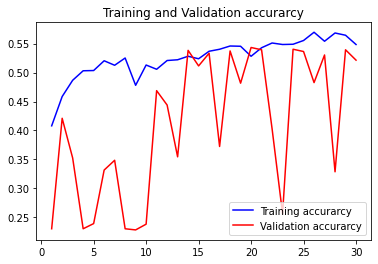

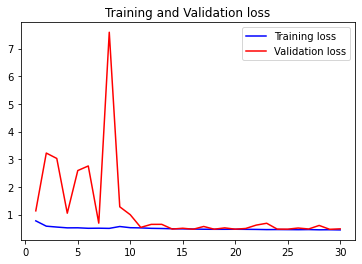

[INFO] Calculating model accuracy
32/32 [==============================] - 46s 1s/step - loss: 0.4826 - accuracy: 0.5214
Test Accuracy: 52.135056257247925
[INFO] Calculating best model accuracy
32/32 [==============================] - 47s 1s/step - loss: 0.4707 - accuracy: 0.5432
Test Accuracy: 54.31976318359375


In [8]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

from keras.models import load_model
new_model = load_model('best_model.h5')
print("[INFO] Calculating best model accuracy")
scores = new_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")


In [13]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmppcr9pu9b/assets


232362352

In [15]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))
pickle.dump(new_model,open('best_cnn_model.pkl', 'wb'))

[INFO] Saving model...


TypeError: ignored